# **ACO: Classical Ant Colony Optimization**

Algoritmo ACO per il TSP scritto a partire da quello del nostro paper basato sull'articolo originale di *Blum e Dorigo (2004)* e riassunto nell'Algoritmo 3.

I parametri di input usati dal paper per l'algoritmo sono simili a quelli utilizzati per QACO, con `βe = 0.4` che esplora in modo più casuale, `maxIter = 62` e `converCondition = 59`, mentre il valore di evaporazione del feromone `ρ = 0.1` è il doppio di quello nel paper ACO originale.

Per imitare completamente l'implementazione di QACO, abbiamo lanciato solo una formica per iterazione di ACO.

In [30]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math

# Parametri ACO
rho = 0.1                  # Evaporazione del feromone
beta_O = 0.4               # Probabilità esplorazione casuale
maxIter = 62               # Numero massimo di iterazioni
converCondition = 59       # Condizione di convergenza
n = 4                      # Dimensione matrice M
minFactor = 2              # Fattore moltiplicativo per il calcolo dell'offset da dare alla fidelity
optimization_mode = 'max'  # Modalità di ottimizzazione: 'max' per massimizzazione, 'min' per minimizzazione
problem_matrix = 4         # Scelta della matrice del problema (1, 2, 3, 4 o 5)

**Definizione della matrice M del problema**\
`M[i,j]` = Costo/Beneficio di attraversare l'arco dal nodo i al nodo j

In [ ]:
import pandas as pd

def load_trial_matrix(problem_matrix):
    """Carica matrice M e vettore soluzione X_th da file CSV"""
    file_path = f"../Trial_matrices/M{problem_matrix}.csv"
    data = pd.read_csv(file_path, header=None)
    
    M = data.iloc[:4, :].values  # Prime 4 righe = matrice
    X_th = data.iloc[4, :].values  # Ultima riga = vettore X
    
    return M, X_th

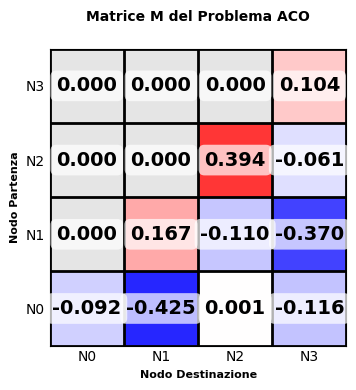

In [29]:
# Visualizzazione della matrice M
def plot_matrix(matrix, title="M Matrix visualization"):
    fig, ax = plt.subplots(figsize=(4, 4))
    
    # Crea una mappa di colori personalizzata
    # Valori negativi -> blu, valori positivi -> rosso
    colors = []
    for i in range(matrix.shape[0]):
        color_row = []
        for j in range(matrix.shape[1]):
            if matrix[i, j] > 0:
                # Intensità del rosso basata sul valore
                intensity = min(abs(matrix[i, j]) * 2, 1)  # Scala l'intensità
                color_row.append([1, 1-intensity, 1-intensity])  # Rosso con gradazioni
            elif matrix[i, j] < 0:
                # Intensità del blu basata sul valore
                intensity = min(abs(matrix[i, j]) * 2, 1)  # Scala l'intensità
                color_row.append([1-intensity, 1-intensity, 1])  # Blu con gradazioni
            else:
                color_row.append([0.9, 0.9, 0.9])  # Grigio chiaro per zero
        colors.append(color_row)
    
    # Disegna la matrice come immagine
    im = ax.imshow(colors, aspect='equal')
    
    # Aggiungi i valori numerici nelle celle
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            # Scegli il colore del testo in base al background
            text_color = 'black'
            
            # Formatta il numero per una migliore leggibilità
            value_text = f'{matrix[i, j]:.3f}'
            
            ax.text(j, i, value_text, 
                   ha='center', va='center', 
                   color=text_color, 
                   fontsize=14, 
                   fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.3", 
                           facecolor='white', 
                           alpha=0.7,
                           edgecolor='none'))
    
    # Personalizza la griglia e le etichette
    ax.set_xlim(-0.5, matrix.shape[1]-0.5)
    ax.set_ylim(-0.5, matrix.shape[0]-0.5)
    
    # Aggiungi linee di griglia eleganti
    for i in range(matrix.shape[0] + 1):
        ax.axhline(i - 0.5, color='black', linewidth=2)
    for j in range(matrix.shape[1] + 1):
        ax.axvline(j - 0.5, color='black', linewidth=2)
    
    # Etichette degli assi
    ax.set_xticks(range(matrix.shape[1]))
    ax.set_yticks(range(matrix.shape[0]))
    ax.set_xticklabels([f'N{i}' for i in range(matrix.shape[1])])
    ax.set_yticklabels([f'N{i}' for i in range(matrix.shape[0])])
    
    # Titolo e labels
    ax.set_title(title, fontsize=10, fontweight='bold', pad=20)
    ax.set_xlabel('Nodo Destinazione', fontsize=8, fontweight='bold')
    ax.set_ylabel('Nodo Partenza', fontsize=8, fontweight='bold')
    
    # Rimuovi i tick marks per un look più pulito
    ax.tick_params(length=0)
    
    plt.tight_layout()
    plt.show()
    
# Applica la visualizzazione alla matrice M
M, X_th = load_trial_matrix(problem_matrix)
plot_matrix(M, "Matrice M del Problema ACO")

**TSE: Traveling Salesman Enhancement**\
Devo trovare il vettore X che ottimizza la fitness function `X @ M @ X.T`, ovvero che in questo caso massimizza/minimizza la somma degli elementi selezionati di M.

## **1. Esplorazione**

Il vettore X è un vettore di variabili binarie che mi dice quali nodi visita la formica. Viene generato attraverso un algoritmo che in parte è completamente randomico (per cercare sempre nuovi percorsi) e in parte utilizza le preferenze dei feromoni, secondo il coefficiente `beta_e`.

In [4]:
def construct_solution(n, ant_position, tau, beta):
    """Costruisce una soluzione per una formica"""
    visited = set([ant_position]) # Crea un insieme (set) che contiene inizialmente solo la posizione corrente della formica
    path = [ant_position] # Inizializzo il percorso con la posizione iniziale della formica
    
    for k in range(n):
        candidates = [i for i in range(1, n + 2) if i not in visited] # n + 2 per tenere conto di n+1
        # Crea una lista di tutti i nodi disponibili che la formica può ancora visitare
        if not candidates:
                break
    
        if random.random() < beta:  
            # Esplorazione casuale
            next_position = random.choice(candidates)
        else:
            # Sfruttamento basato sui feromoni   
            values = [tau[ant_position, i] for i in candidates]
            probs = np.array(values) # Vettore delle probabilità basato sui feromoni
            probs_sum = probs.sum() # Somma totale delle probabilità
        
            if probs_sum == 0: # Nessun feromone, esplorazione casuale
                probs = (np.ones(len(candidates)))  /  len(candidates) # Probabilità uniforme
            else:
                probs = probs / probs_sum
                
            next_position = random.choices(candidates, weights=probs)[0] # Scelta ponderata, mi da una lista 1 elemento

        ant_position = next_position # Aggiorna la posizione della formica
        visited.add(ant_position) # Aggiunge la nuova posizione all'insieme dei nodi visitati
        path.append(ant_position) # Aggiunge la nuova posizione al percorso
        
        if ant_position == n + 1:
            break
        
    return path # Restituisce il percorso completo della formica

def generate_solution_vector(n, path):
    """Genera il vettore soluzione X"""
    X = np.zeros(n)
    for node in path:
        if 1 <= node <= n:
            X[node-1] = 1 # Accendo variabili binarie passaggio nei nodi
    return X

## **2. Bontà della soluzione**

Problema: alcuni elementi di M sono negativi, quindi la somma potrebbe essere negativa\
`epsilon = 1e-6`: Piccolo valore positivo per evitare zero

- Caso negativo: L'offset è abbastanza grande da garantire che anche il peggior risultato possibile diventi positivo
- Caso positivo: L'offset è minimo per non alterare significativamente i valori
- Epsilon sempre presente: Evita il valore zero esatto (che causerebbe divisione per zero in rho/fitness)

In [5]:
def calculate_fitness(X, M):
    """Calcola la fitness con offset per evitare valori negativi"""
    raw_fitness = X @ M @ X.T # Calcolo della fitness reale
    epsilon = 1e-6
    min_value = np.min(M)
    
    if min_value < 0:
       offset = abs(minFactor*min_value) + epsilon # Offset 2*valore minimo per evitare negativi. Il 2* è scelto a caso ma funziona atm
    else:
       offset = epsilon

    return (raw_fitness + offset), raw_fitness

## **3. Feromoni**

Negli algoritmi ACO, il modello probabilistico è chiamato **modello dei feromoni**. Il modello dei feromoni consiste in un insieme di parametri del modello, chiamati **parametri delle tracce di feromone**. I parametri delle tracce di feromone hanno dei valori, chiamati **valori dei feromoni**. Durante l'esecuzione, gli algoritmi ACO cercano di aggiornare i valori dei feromoni in modo tale che la probabilità di generare soluzioni di alta qualità aumenti nel tempo.

I feromoni **sono sugli archi tra i nodi**, mentre nella QAP sono sui nodi.
- I feromoni sono memorizzati nella matrice `tau[a, b]`
- Ogni cella `tau[a, b]` rappresenta la quantità di feromone sull'arco che va dal nodo `a` al nodo `b`

In [6]:
# Inizializzazione matrice dei feromoni tau
def initialize_pheromones(n):
    """Inizializza la matrice dei feromoni a zero"""
    return np.zeros((n+2, n+2)) # +2 per includere nodo di partenza e arrivo

def update_pheromones(tau, path, fitness, rho, n, optimization_mode):
    """Aggiorna i valori del feromone"""
    # Evaporazione su tutti gli archi
    for i in range(n):
        for j in range(n):
            tau[i, j] = (1 - rho) * tau[i, j]
    
    # Deposito proporzionale alla fitness da entrambi i lati della matrice (grafo non orientato)  
    for i in range(len(path)-1):
        a, b = path[i], path[i+1] #Ad a e b vengono assegnati il numero dei nodi di un certo arco a->b.
        # Quindi l'entrata della matrice tau[a, b] rappresenta la quantità di feromone sull'arco che va dal nodo a al nodo b.
        if optimization_mode == 'min':
            tau[a, b] += (rho / fitness)
            tau[b, a] += (rho / fitness)
            # Deposito inversamente proporzionale alla fitness da entrambi i lati della matrice (grafo non orientato)
        elif optimization_mode == 'max':
            tau[a, b] += 1 - (rho / fitness)
            tau[b, a] += 1 - (rho / fitness)
        else:
            raise ValueError("Invalid optimization mode. Choose 'max' or 'min'.")
    return tau

In [7]:
def plot_pheromone_matrix(tau, title="Matrice Feromoni - Visualizzazione"):
    """
    Visualizza la matrice dei feromoni con sfumature rosa
    - Intensità rosa proporzionale al valore del feromone
    - Valori numerici nelle celle
    - Griglia elegante
    """
    fig, ax = plt.subplots(figsize=(4, 4))
    
    # Normalizza i valori per la mappa di colori
    tau_max = np.max(tau)
    tau_min = np.min(tau)
    
    if tau_max == tau_min:  # Tutti i valori sono uguali
        normalized_tau = np.zeros_like(tau)
    else:
        normalized_tau = (tau - tau_min) / (tau_max - tau_min)
    
    # Crea la mappa di colori rosa
    colors = []
    for i in range(tau.shape[0]):
        color_row = []
        for j in range(tau.shape[1]):
            intensity = normalized_tau[i, j]
            if tau[i, j] == 0:
                # Bianco per valori zero
                color_row.append([1.0, 1.0, 1.0])
            else:
                # Sfumature di rosa: più intenso = più scuro
                # RGB per rosa: (1, rosa_component, rosa_component)
                pink_component = 1 - (intensity * 0.7)  # Da 1 (bianco) a 0.3 (rosa scuro)
                color_row.append([1.0, pink_component, pink_component])
        colors.append(color_row)
    
    # Disegna la matrice
    im = ax.imshow(colors, aspect='equal')
    
    # Aggiungi i valori numerici nelle celle
    for i in range(tau.shape[0]):
        for j in range(tau.shape[1]):
            text_color = 'black'
            
            # Formatta il numero
            if tau[i, j] == 0:
                value_text = '0'
            else:
                value_text = f'{tau[i, j]:.4f}'
            
            ax.text(j, i, value_text, 
                   ha='center', va='center', 
                   color=text_color, 
                   fontsize=6, 
                   fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.2", 
                           facecolor='white', 
                           alpha=0.8,
                           edgecolor='none'))
    
    # Personalizza la griglia
    ax.set_xlim(-0.5, tau.shape[1]-0.5)
    ax.set_ylim(-0.5, tau.shape[0]-0.5)
    
    # Linee di griglia eleganti
    for i in range(tau.shape[0] + 1):
        ax.axhline(i - 0.5, color='black', linewidth=1.5)
    for j in range(tau.shape[1] + 1):
        ax.axvline(j - 0.5, color='black', linewidth=1.5)
    
    # Etichette degli assi
    ax.set_xticks(range(tau.shape[1]))
    ax.set_yticks(range(tau.shape[0]))
    ax.set_xticklabels([f'N{i}' for i in range(tau.shape[1])])
    ax.set_yticklabels([f'N{i}' for i in range(tau.shape[0])])
    
    # Titolo e labels
    ax.set_title(title, fontsize=10, fontweight='bold', pad=20)
    ax.set_xlabel('Nodo Destinazione', fontsize=8, fontweight='bold')
    ax.set_ylabel('Nodo Partenza', fontsize=8, fontweight='bold')

    
    plt.tight_layout()
    plt.show()

### **3.1 Stopping criteria**

**From our paper**\
*In ACO, we have to define a termination condition for the algorithm to exit the iteration loop. 
When we have no prior information about a lower bound for the optimal solution, we can define 2 different conditions (p. 105 Dorigo and St ̈utzle 2004).*

1. *One can be to set a fixed maximum time or iterations the algorithm can run.   
   Using this criterion, making an infinite number of iterations will yield the correct result to the problem, as every possible path is allowed to be obtained in every iteration. This way, the probability of getting the result after infinite iterations will be 100%.*

   *Although valid, this termination criterion is not useful, as it is difficult to set the correct number of iterations a priori. Besides, the number of iterations could be set higher than necessary, lowering the efficiency of the algorithm.
2. *The other termination condition can be set to define a **convergence or stagnation condition**.*
   *This can be understood as having a situation in which no better results are found on consecutive iterations. To take this into account, we introduced a new parameter ```converCondition```. At the end of each iteration, the algorithm checks if the result is better than the best solution so far.*

## **4. Algoritmo ACO**

In [14]:
### Inizializzazione ###
tau = initialize_pheromones(n)
print("Matrice feromoni iniziale:")
print(tau)

best_solution = None
best_X = None

if optimization_mode == 'max':
    best_offset_fitness = float(0) # settato a 0
elif optimization_mode == 'min':
    best_offset_fitness = float('inf') # settato a infinito

count = 1

Matrice feromoni iniziale:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


NUOVA MIGLIORE SOLUZIONE TROVATA:
Soluzione migliore proposta (Iter. 1):  [0, 3, 4, 1, 5]
Vettore X n. 1 generato:  [1. 0. 1. 1.]
Fitness della nuova migliore soluzione (Iter. 1):  1.02
Fitness 1 offsettata usata per aggiornare il feromone:  1.7940010000000002


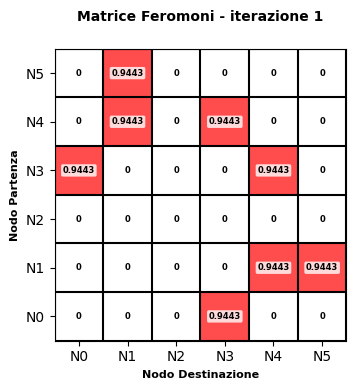

Distanza dalla miglior soluzione trovata:  1
Distanza dalla miglior soluzione trovata:  2
Distanza dalla miglior soluzione trovata:  3
Distanza dalla miglior soluzione trovata:  4
Distanza dalla miglior soluzione trovata:  5
Distanza dalla miglior soluzione trovata:  6
Distanza dalla miglior soluzione trovata:  7
Distanza dalla miglior soluzione trovata:  8
Distanza dalla miglior soluzione trovata:  8
Distanza dalla miglior soluzione trovata:  9
Distanza dalla miglior soluzione trovata:  10
Distanza dalla miglior soluzione trovata:  11
Distanza dalla miglior soluzione trovata:  12
Distanza dalla miglior soluzione trovata:  13
Distanza dalla miglior soluzione trovata:  14
Distanza dalla miglior soluzione trovata:  15
Distanza dalla miglior soluzione trovata:  16
Distanza dalla miglior soluzione trovata:  17
Distanza dalla miglior soluzione trovata:  18
Distanza dalla miglior soluzione trovata:  19
Distanza dalla miglior soluzione trovata:  20
Distanza dalla miglior soluzione trovata:  2

In [ ]:
# Loop principale
for j in range(maxIter):
    # Beta si potrebbe aumentare linearmente con le iterazioni
    # beta = beta_O + ((1-beta_O)/(maxIter)) * j
    beta = beta_O
    is_better = False
    
    # Costruzione della soluzione
    ant_position = 0
    path = construct_solution(n, ant_position, tau, beta)
    # Generazione vettore X
    X = generate_solution_vector(n, path)
    
    # Calcolo fitness della soluzione con matrice del problema
    offset_fitness = calculate_fitness(X, M)[0]
    real_fitness = calculate_fitness(X, M)[1]
    
    if offset_fitness <= 0:
        print("!!!Errore!!!\nFitness offsettata non positiva.")
        print("Fitness offsettata:", offset_fitness)
        break
    
    # Aggiornamento feromoni
    tau = update_pheromones(tau, path, offset_fitness, rho, n, optimization_mode)
    # Verifica miglior soluzione
    if path != [0, n + 1 ]: # Evito soluzione banale. Potrei toglierla anche prima
        if optimization_mode == 'max':
            is_better = offset_fitness > best_offset_fitness
        elif optimization_mode == 'min':
            is_better = offset_fitness < best_offset_fitness
        if is_better:
            best_offset_fitness = offset_fitness
            best_real_fitness = real_fitness
            best_solution = path
            best_X = X.copy() # Copia del vettore X
            count = 1
            
            print('NUOVA MIGLIORE SOLUZIONE TROVATA:')
            print(f'Soluzione migliore proposta (Iter. {j+1}): ', best_solution)
            print(f'Vettore X n. {j+1} generato: ', best_X)
            print(f'Fitness della nuova migliore soluzione (Iter. {j+1}): ', best_real_fitness)
            print(f'Fitness {j+1} offsettata usata per aggiornare il feromone: ', best_offset_fitness)
            plot_pheromone_matrix(tau, title=f"Matrice Feromoni - iterazione {j+1}")
        else:
            count += 1 # Distanza dalla miglior soluzione trovata
        
    # Verifica convergenza
    # print('Distanza dalla miglior soluzione trovata: ', count)
    if count >= converCondition:
        print(f"Convergenza raggiunta dopo {j+1} iterazioni.")
        break
    if j == maxIter - 1:
        print("--------------------------------")
        print(f"NUMERO MASSIMO DI ITERAZIONI ({maxIter}) RAGGIUNTO SENZA CONVERGENZA.")
        print(f"Miglior soluzione trovata dopo {j+1} iterazioni:")
        print("Percorso migliore:", best_solution)
        print("Vettore X migliore:", best_X)
        print("Fitness della miglior soluzione:", best_real_fitness)
        
count = 1
print("================================")

Matrice feromoni finale:


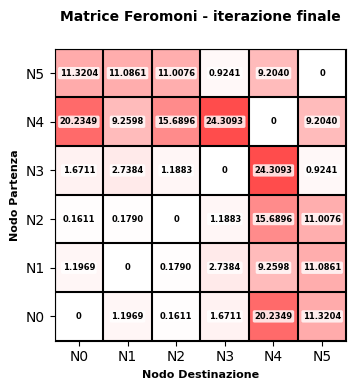

Miglior soluzione trovata:
Percorso (nodi visitati): [0, 3, 4, 1, 5]
Vettore soluzione X: [1. 0. 1. 1.]
Fitness della miglior soluzione: 1.02
Fitness teorica della soluzione nota: [1 0 1 1] 1.02


In [16]:
print("Matrice feromoni finale:")
plot_pheromone_matrix(tau, title="Matrice Feromoni - iterazione finale")

print("Miglior soluzione trovata:")
print("Percorso (nodi visitati):", best_solution)

print("Vettore soluzione X:", best_X)
print("Fitness della miglior soluzione:", best_real_fitness)

# X_th = np.array([1, 0, 1, 1]) # Soluzione nota
print(f"Fitness teorica della soluzione nota: {X_th}", X_th @ M @ X_th.T)